In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model


In [2]:
metadata  = pd.read_csv("HAM10000_metadata.csv")

In [3]:
print(metadata.head())

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


Datacleaning

In [ ]:
# Number of missing values per column
missing_values = metadata.isnull().sum()

# Percentage of missing values per column
missing_percentage = (missing_values / len(metadata)) * 100

# Overview of the missing values
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

# Only display columns with missing values
missing_summary = missing_summary[missing_summary['Missing Values'] > 0]

print("Missing values in the data set:")
print(missing_summary)


Fehlende Werte im Datensatz:
     Missing Values  Percentage
age              57    0.569146


In [ ]:
# Remove the rows with missing age values
metadata_cleaned = metadata.dropna(subset=['age'])

# Check whether there are still missing values
print("Verbleibende fehlende Werte nach der Bereinigung:")
print(metadata_cleaned.isnull().sum())

Verbleibende fehlende Werte nach der Bereinigung:
lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64


End Datacleaning

In [ ]:
# Categorical columns
categorical_cols = ['sex', 'localization']

# One-hot encoding for categorical variables
metadata = pd.get_dummies(metadata_cleaned, columns=categorical_cols)


In [ ]:
# Label encoder for diagnostics

label_encoder = LabelEncoder()
metadata['label'] = label_encoder.fit_transform(metadata['dx'])


In [8]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9958 entries, 0 to 10014
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   lesion_id                     9958 non-null   object 
 1   image_id                      9958 non-null   object 
 2   dx                            9958 non-null   object 
 3   dx_type                       9958 non-null   object 
 4   age                           9958 non-null   float64
 5   sex_female                    9958 non-null   bool   
 6   sex_male                      9958 non-null   bool   
 7   sex_unknown                   9958 non-null   bool   
 8   localization_abdomen          9958 non-null   bool   
 9   localization_acral            9958 non-null   bool   
 10  localization_back             9958 non-null   bool   
 11  localization_chest            9958 non-null   bool   
 12  localization_ear              9958 non-null   bool   
 13  localiz

 Loading and pre-processing images

In [ ]:
image_folder = './HAM10000_images'

IMAGE_SIZE = (128, 128)

def load_image(image_id):
    image_path = os.path.join(image_folder, image_id + '.jpg')
    try:
        image = Image.open(image_path).resize(IMAGE_SIZE)
        image = np.array(image) / 255.0  # Normalisierung
        return image
    except:
        return None


In [ ]:
metadata['image'] = metadata['image_id'].apply(load_image)

# Remove entries with failed image loading
metadata = metadata[metadata['image'].notnull()]


Prepare features and labels

In [11]:
X_images = np.stack(metadata['image'].values)


In [ ]:
metadata_features = metadata.drop(['lesion_id', 'image_id', 'dx', 'dx_type', 'image', 'label'], axis=1)


scaler = StandardScaler()
numerical_cols = ['age']
metadata_features[numerical_cols] = scaler.fit_transform(metadata_features[numerical_cols])

X_metadata = metadata_features.values


In [13]:
y = tf.keras.utils.to_categorical(metadata['label'], num_classes=len(metadata['label'].unique()))


In [14]:
X_images_train, X_images_test, X_metadata_train, X_metadata_test, y_train, y_test = train_test_split(
    X_images, X_metadata, y, test_size=0.2, random_state=42
)


In [ ]:

X_images_train = np.array(X_images_train, dtype=np.float32)
X_metadata_train = np.array(X_metadata_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

X_images_test = np.array(X_images_test, dtype=np.float32)
X_metadata_test = np.array(X_metadata_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

Create model

In [ ]:

image_input = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# CNN-Schichten
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)


In [ ]:

metadata_input = Input(shape=(X_metadata.shape[1],))

# DNN-Schichten
m = layers.Dense(64, activation='relu')(metadata_input)
m = layers.Dropout(0.5)(m)
m = layers.Dense(32, activation='relu')(m)


In [ ]:
# Merge

combined = layers.concatenate([x, m])

# Ausgabeschicht
z = layers.Dense(64, activation='relu')(combined)
z = layers.Dense(y.shape[1], activation='softmax')(z)


In [19]:
model = Model(inputs=[image_input, metadata_input], outputs=z)


Compile and train model

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [21]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      1,280 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │     10,304 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 7)         │        455 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 123,879 (483.90 KB)

 Trainable params: 123,879 (483.90 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
print(type(X_images_train), X_images_train.dtype)
print(type(X_metadata_train), X_metadata_train.dtype)
print(type(y_train), y_train.dtype)
print(type(X_images_test), X_images_test.dtype)
print(type(X_metadata_test), X_metadata_test.dtype)
print(type(y_test), y_test.dtype)

<class 'numpy.ndarray'> float32
<class 'numpy.ndarray'> float32
<class 'numpy.ndarray'> float32
<class 'numpy.ndarray'> float32
<class 'numpy.ndarray'> float32
<class 'numpy.ndarray'> float32


In [23]:
history = model.fit(
    [X_images_train, X_metadata_train],
    y_train,
    validation_data=([X_images_test, X_metadata_test], y_test),
    epochs=40,
    batch_size=32
)


Epoch 1/40


c:\Users\tillb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_9']. Received: the structure of inputs=('*', '*')
  warnings.warn(


249/249 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.6447 - loss: 1.1466 - val_accuracy: 0.7083 - val_loss: 0.8722
Epoch 2/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.6932 - loss: 0.8937 - val_accuracy: 0.7199 - val_loss: 0.8328
Epoch 3/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.7064 - loss: 0.8743 - val_accuracy: 0.7164 - val_loss: 0.7993
Epoch 4/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.7086 - loss: 0.8077 - val_accuracy: 0.7214 - val_loss: 0.7548
Epoch 5/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.7209 - loss: 0.7720 - val_accuracy: 0.7123 - val_loss: 0.7946
Epoch 6/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.7127 - loss: 0.7694 - val_accuracy: 0.7229 - val_loss: 0.7520
Epoch 7/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.7226 - loss: 0.7414 - val_accuracy: 0.7264 - val_loss: 0.7135
Epoch 8/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.7190 - loss: 0.7490 - val_accurac

In [ ]:
#evaluate
loss, accuracy = model.evaluate([X_images_test, X_metadata_test], y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7639 - loss: 0.6093
Test Loss: 0.5879
Test Accuracy: 0.7781


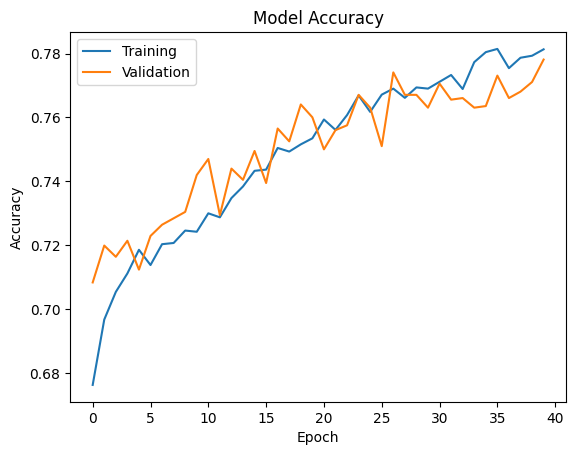

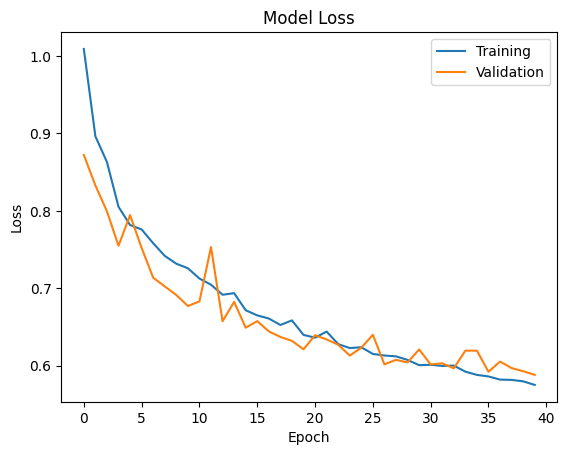

In [ ]:
import matplotlib.pyplot as plt

# accuracy
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#loss
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [26]:
# model.save('skin_cancer_classifier.h5')

In [35]:
# Vorhersagen auf den Testdaten
y_pred = model.predict([X_images_test, X_metadata_test])

# Konvertieren der Vorhersagen in Klassen (argmax für One-Hot-Encoding)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)  # Wahre Klassen aus One-Hot-Encoding


 4/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

c:\Users\tillb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_9']. Received: the structure of inputs=('*', '*')
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [ ]:
from sklearn.metrics import classification_report

# metric
target_names = label_encoder.classes_  # Klassenbezeichnungen aus dem Label-Encoder
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))


              precision    recall  f1-score   support

       akiec       0.35      0.40      0.37        65
         bcc       0.43      0.57      0.49        91
         bkl       0.62      0.41      0.49       225
          df       0.55      0.38      0.45        29
         mel       0.54      0.52      0.53       225
          nv       0.89      0.93      0.91      1336
        vasc       0.93      0.67      0.78        21

    accuracy                           0.78      1992
   macro avg       0.62      0.55      0.58      1992
weighted avg       0.77      0.78      0.77      1992



In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Precision, Recall und F1-Score (Durchschnitt über alle Klassen)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')  # 'macro' oder 'micro' als Alternative
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Precision: 0.7745
Recall: 0.7781
F1-Score: 0.7728


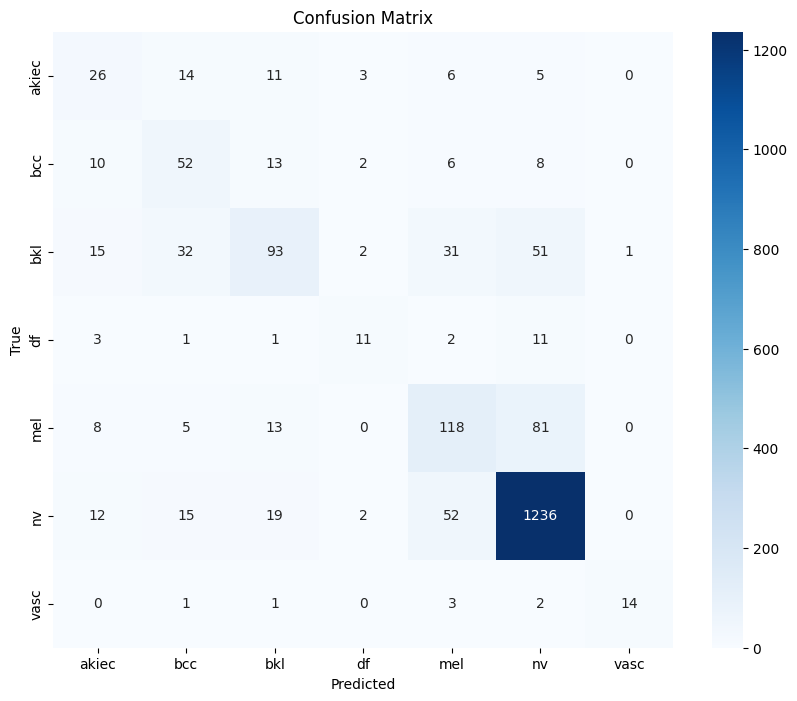

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:

y_pred = model.predict([X_images_test, X_metadata_test])

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


from sklearn.metrics import classification_report, precision_score, recall_score, f1_score


target_names = label_encoder.classes_  # Klassenbezeichnungen aus dem Label-Encoder
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))


precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"\nPrecision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

Classification Report:
              precision    recall  f1-score   support

       akiec       0.35      0.40      0.37        65
         bcc       0.43      0.57      0.49        91
         bkl       0.62      0.41      0.49       225
          df       0.55      0.38      0.45        29
         mel       0.54      0.52      0.53       225
          nv       0.89      0.93      0.91      1336
        vasc       0.93      0.67      0.78        21

    accuracy                           0.78      1992
   macro avg       0.62      0.55      0.58      1992
weighted avg       0.77      0.78      0.77      1992


Precision (weighted): 0.7745
Recall (weighted): 0.7781
F1-Score (weighted): 0.7728
